In [1]:
import pandas as pd
import numpy as np

In [2]:
df=pd.read_csv('data.csv',encoding="latin1")

/var/folders/0n/cb4msb_j7vq0sq7_bpccc2040000gn/T/ipykernel_76378/1029817289.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('data.csv',encoding="latin1")


In [3]:
df.head()

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [4]:
df.shape

(435742, 13)

In [5]:
data_sum=df['no2'].isnull().sum()
data_sum

16233

In [6]:
x=df['no2'].dropna().values

In [8]:
r=102317136
ar=0.5*(r%7)
br=0.3*(r%5+1)


In [9]:
ar

2.5

In [10]:
br

0.6

In [11]:
#step1:transformation
z = x+ar * np.sin(br * x)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim


In [13]:
ztensor = torch.tensor(z, dtype=torch.float32).view(-1, 1)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [16]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
optimizer_G = optim.Adam(G.parameters(), lr=0.001)
optimizer_D = optim.Adam(D.parameters(), lr=0.001)

In [17]:
epochs = 3000
batch_size = 64

for epoch in range(epochs):

    idx = np.random.randint(0, len(ztensor), batch_size)
    real_samples = ztensor[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)

    D_real = D(real_samples)
    D_fake = D(fake_samples.detach())

    loss_D = criterion(D_real, real_labels) + criterion(D_fake, fake_labels)

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

#training the generator

    noise = torch.randn(batch_size, 1)
    fake_samples = G(noise)
    D_fake = D(fake_samples)

    loss_G = criterion(D_fake, real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

Epoch 0 | D Loss: 2.0310 | G Loss: 0.7549
Epoch 500 | D Loss: 1.3681 | G Loss: 0.7527
Epoch 1000 | D Loss: 1.3893 | G Loss: 0.6587
Epoch 1500 | D Loss: 1.3871 | G Loss: 0.6836
Epoch 2000 | D Loss: 1.4039 | G Loss: 0.6851
Epoch 2500 | D Loss: 1.3860 | G Loss: 0.6897


In [18]:
#Generating samples from Generator
noise = torch.randn(10000, 1)
zfake = G(noise).detach().numpy()


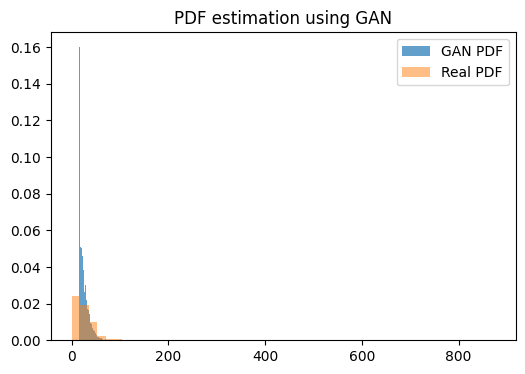

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.hist(zfake, bins=50, density=True, alpha=0.7, label="GAN PDF")
plt.hist(z, bins=50, density=True, alpha=0.5, label="Real PDF")
plt.legend()
plt.title("PDF estimation using GAN")
plt.show()